In [16]:
suppressPackageStartupMessages({
  library(cowplot)
  library(dataorganizer)
  library(ggplot2)
  library(ggrastr)
  library(data.table)
  library(readr)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks


In [2]:
# loading the spatial data and metadata
data <- prepare_OC_sc_spatial()
df <- data[[1]]
cell_annot <- data[[2]]

In [5]:
## first, identifying spatial regions using cell-wise knn matrix
xn = cell_annot %>% select(x, y) %>% FNN::get.knn(k = 20) %>% .$nn.index
ct_dict = cell_annot %>% mutate(id = 1:n()) %>% {setNames(.$cell_type, .$id)}
cell_dict = cell_annot %>% mutate(id = 1:n()) %>% {setNames(.$cell, .$id)}
nmat = apply(xn, 2, function(i){ct_dict[i]})

ct_counts = nmat %>%
  reshape2::melt() %>%
  select(id = Var1, ct = value) %>%
  mutate(
    cell = cell_dict[id]
  ) %>%
  select(-id) %>%
  as.data.table %>%
  mutate(ct = paste0('n_', ct)) %>%
  count(cell, ct, .drop = TRUE) %>%
  dcast(cell ~ ct, value.var = 'n', fill = 0)

ct_counts <- as.data.frame(ct_counts)
rownames(ct_counts) <- ct_counts$cell
ct_counts$cell <- NULL
ct_counts <- as.matrix(ct_counts)

In [6]:
dim(ct_counts)

[1] 352670     15

In [7]:
# run clustering to identify spatial regions
num_clusters <- 5
kmeans_res <- kmeans(ct_counts, centers = num_clusters)
table(kmeans_res$cluster)


     1      2      3      4      5 
 44794  74477  64974  66458 101967 

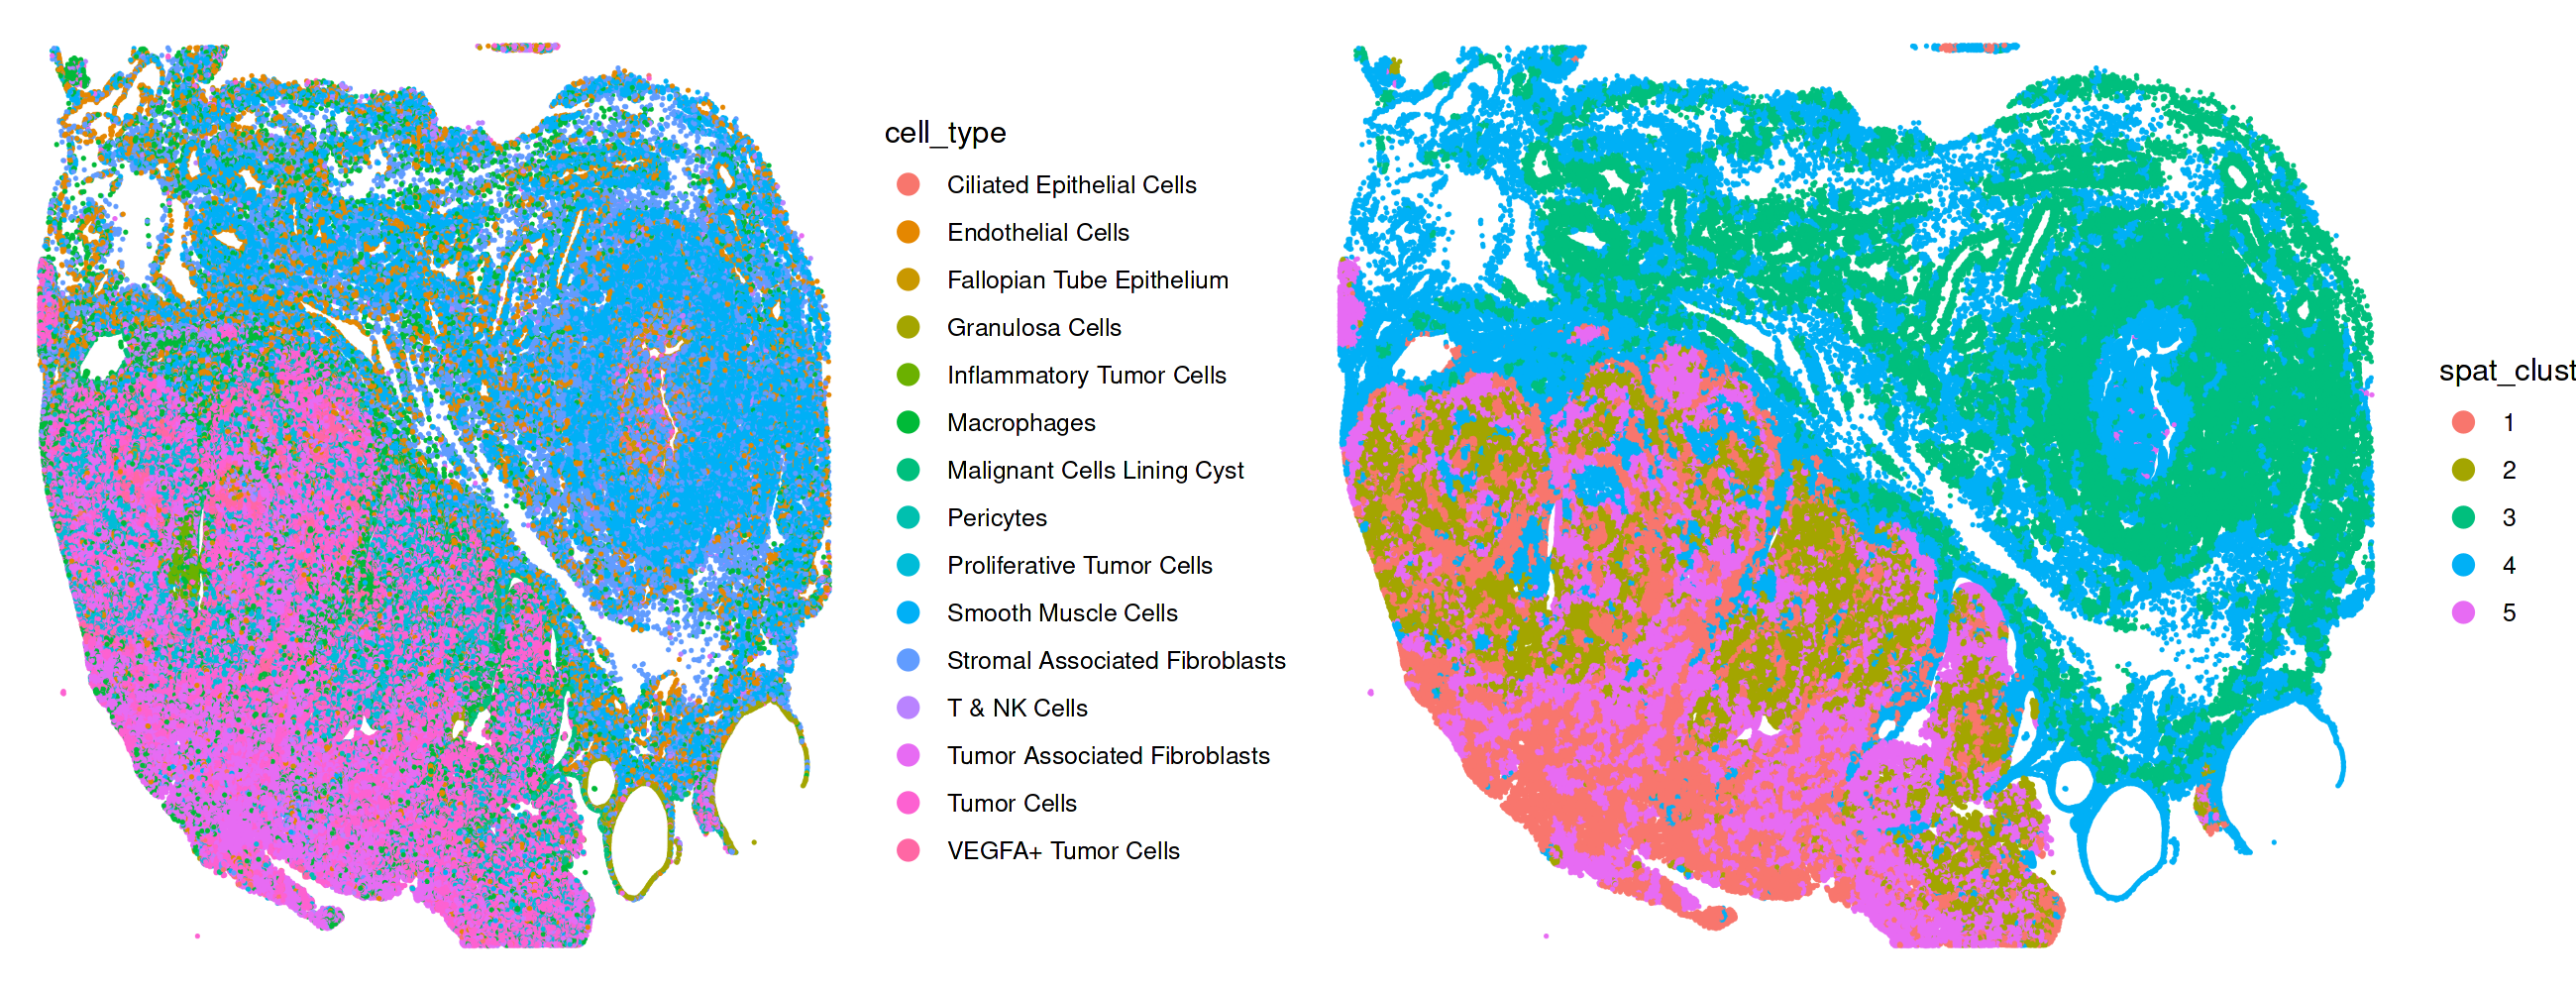

In [13]:
options(repr.plot.width = 13, repr.plot.height = 5, repr.plot.res = 200)

spat_clusts <- cbind.data.frame(cell_annot[,c('x','y','cell_type')],kmeans_res$cluster)
colnames(spat_clusts)[ncol(spat_clusts)] <- 'spat_clust'
spat_clusts$spat_clust <- as.factor(spat_clusts$spat_clust)

p1 <- ggplot(spat_clusts,aes(x=x,y=y,color=cell_type)) +
  geom_point_rast(size=.001) +
  guides(colour = guide_legend(override.aes = list(size=3))) +
  theme_void()

p2 <- ggplot(spat_clusts,aes(x=x,y=y,color=spat_clust)) +
  geom_point_rast(size=.001) +
  guides(colour = guide_legend(override.aes = list(size=3))) +
  theme_void()

fig <- plot_grid(p1,p2,nrow=1,align='h')
fig

In [14]:
pdf(OutputPath("oc_slide.pdf"), useDingbats = FALSE, width = 13, height = 5)
fig
dev.off()

png 
  2

In [19]:
# saving the annotation for DE later
write_rds(spat_clusts, CachePath('OC_spatial_clustering.rds'))

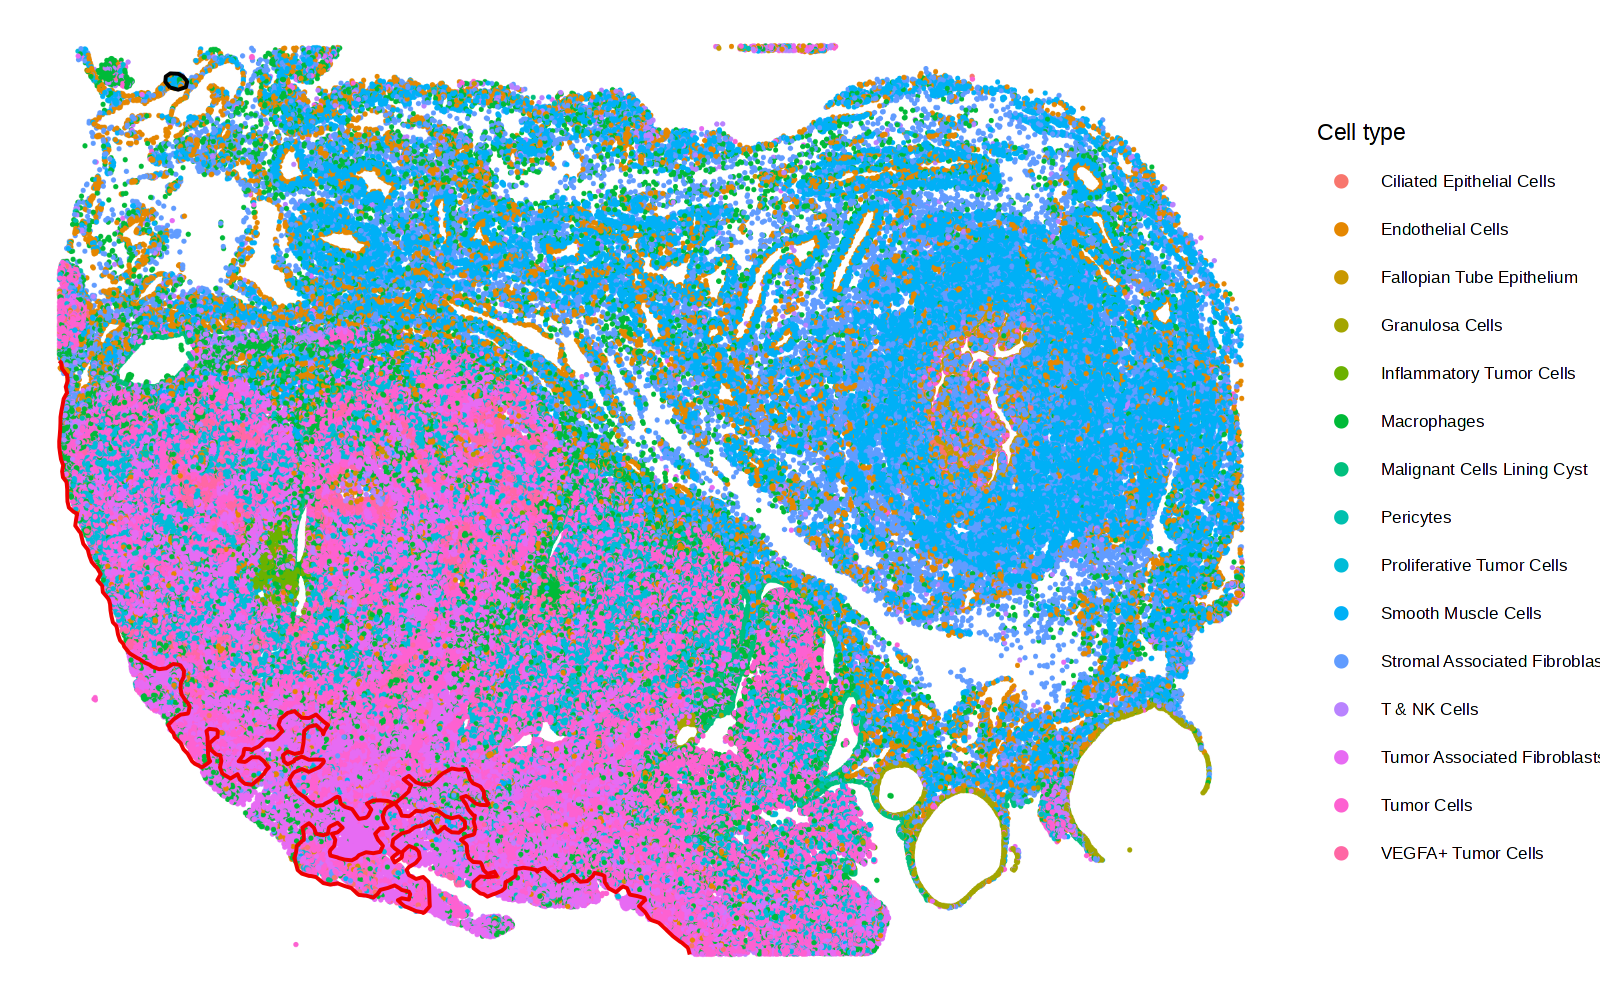

In [20]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)

cell_annot$niche <- spat_clusts$spat_clust
p <- ggplot(cell_annot,aes(x=x,y=y,color=cell_type)) +
  geom_point_rast(size=.001) +
  #   scale_color_brewer(palette = "Spectral") +
  guides(colour = guide_legend(override.aes = list(size=3)))

conf="1%"

predicted_y_all <- (140375/17) - (cell_annot$x * (47/68))
cell_annot_sub <- cell_annot[as.character(cell_annot$niche) %in% c(2,4,5) & cell_annot$y<predicted_y_all,]
# cell_annot_sub <- cell_annot[as.character(cell_annot$niche) %in% c(2,5) & cell_annot$y<predicted_y_all,]

emb <- cell_annot_sub
emb <- emb[,c('x','y')]

# kd <- ks::kde(emb, compute.cont=TRUE)
h <- matrix(c(.05, 0, 0, .05), ncol=2)
kd <- ks::kde(emb, compute.cont=TRUE, H=h)
lcn <- kd %$% contourLines(x=eval.points[[1]], y=eval.points[[2]], z=estimate, levels=cont[conf]) %>%
  .[[1]] %>% data.frame() %>% cbind(z=1)
cn <- geom_path(aes(x, y), data=lcn, color='red2')

p <- p + cn


conf="1%"

# pair1 <- c(3700,5700)
# pair2 <- c(10500,1000)
# y = (140375/17) - ((47*x)/68)
predicted_y_all <- (140375/17) - (cell_annot$x * (47/68))

cell_annot_sub <- cell_annot[as.character(cell_annot$niche) %in% c(1,3) & cell_annot$y>predicted_y_all,]

emb <- cell_annot_sub
emb <- emb[,c('x','y')]

kd <- ks::kde(emb, compute.cont=TRUE)
# h <- matrix(c(.1, 0, 0, .1), ncol=2)
# kd <- ks::kde(emb, compute.cont=TRUE, H=h)
lcn <- kd %$% contourLines(x=eval.points[[1]], y=eval.points[[2]], z=estimate, levels=cont[conf]) %>%
  .[[1]] %>% data.frame() %>% cbind(z=1)
cn <- geom_path(aes(x, y), data=lcn, color='black')

p <- p + cn

p <- p +
  labs(color='Cell type') +
  theme_void() +
  legend_mod +
  theme(text = element_text(family = font_choice),
        legend.text=element_text(size=6),
        legend.title=element_text(size=8))

p

In [21]:
# getting height width ratio to keep aspect ratio accurate in the pdf
x_diff <- max(cell_annot$x) - min(cell_annot$x)
y_diff <- max(cell_annot$y) - min(cell_annot$y)
aspect_ratio <- y_diff / x_diff

width_plot <- 3
height_plot <- aspect_ratio * width_plot
print(height_plot)

[1] 2.08143


In [22]:
pdf(OutputPath("oc_tumor_region_no_legend.pdf"), useDingbats=FALSE, width=width_plot, height=height_plot)
p + theme(legend.position="none")
dev.off()

png 
  2

In [23]:
pdf(OutputPath("oc_tumor_region.pdf"), useDingbats=FALSE, width=width_plot+1, height=height_plot)
p
dev.off()

png 
  2

In [24]:
unique(cell_annot$cell_type)

[1] "Proliferative Tumor Cells"      "Tumor Cells"                   
 [3] "Ciliated Epithelial Cells"      "Inflammatory Tumor Cells"      
 [5] "Macrophages"                    "T & NK Cells"                  
 [7] "Tumor Associated Fibroblasts"   "VEGFA+ Tumor Cells"            
 [9] "Malignant Cells Lining Cyst"    "Endothelial Cells"             
[11] "Fallopian Tube Epithelium"      "Stromal Associated Fibroblasts"
[13] "Smooth Muscle Cells"            "Granulosa Cells"               
[15] "Pericytes"

In [25]:
cell_annot$cell_type_coarse <- sapply(cell_annot$cell_type,function(ct) {
    if (ct %in% c('Proliferative Tumor Cells','Tumor Cells','Inflammatory Tumor Cells','VEGFA+ Tumor Cells',
                'Malignant Cells Lining Cyst')) {
        return('Tumor Cells')
    } else {
        return(ct)
    }
})

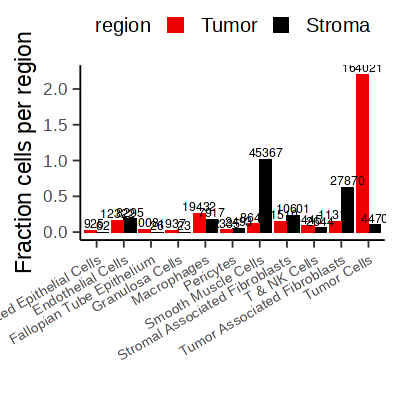

In [26]:
options(repr.plot.width = 2, repr.plot.height = 2, repr.plot.res = 200)

## compute counts of each cell type in each region
cell_annot_stroma <- cell_annot[cell_annot$niche %in% c(1,3),]
ct_counts_stroma <- table(cell_annot_stroma$cell_type_coarse)
cell_annot_tumor <- cell_annot[cell_annot$niche %in% c(2,4,5),]
ct_counts_tumor <- table(cell_annot_tumor$cell_type_coarse)

c1 <- c(ct_counts_stroma,ct_counts_tumor)
c2 <- c(names(ct_counts_stroma),names(ct_counts_tumor))
c3 <- c(rep('Stroma',length(ct_counts_stroma)),rep('Tumor',length(ct_counts_tumor)))
ct_fracs <- cbind.data.frame(c1,c2,c3)
colnames(ct_fracs) <- c('counts','cell_type','region')
ct_fracs$cell_type <- as.factor(ct_fracs$cell_type)
ct_fracs$region <- factor(ct_fracs$region,levels=c('Tumor','Stroma'))
ct_fracs2 <- ct_fracs

total_counts <- table(cell_annot$niche)
ndx1 <- which(names(total_counts) %in% c(1,3))
ndx2 <- which(names(total_counts) %in% c(2,4,5))
names(total_counts)[ndx1] <- 'Stroma'
names(total_counts)[ndx2] <- 'Tumor'

match_ndx <- match(ct_fracs2$region,names(total_counts))
ct_fracs2$total_counts <- total_counts[match_ndx]
ct_fracs2$fracs <- ct_fracs2$counts / ct_fracs2$total_counts
p <- ggplot(ct_fracs2,aes(x=cell_type,y=fracs,fill=region)) +
  geom_bar(position = "dodge", stat = "identity") +
  geom_text(aes(label=counts), position=position_dodge(width=0.9), vjust=-0.25, size=(3*geom_text_size)/4) +
  ylim(c(0,max(ct_fracs2$fracs)+.02)) +
  xlab('') +
  ylab('Fraction cells per region') +
  theme_classic(base_line_size = gg_line_thickness) +
  scale_fill_manual(breaks = c('Tumor','Stroma'),values = c('red2','black')) +
  p_theme +
  theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1,size=5),
       legend.key.size = unit(7, 'pt'),
        legend.key.height = unit(7, 'pt'),
        legend.key.width = unit(7, 'pt'),
        legend.title=element_text(size=7),
        legend.text=element_text(size=7),
       axis.title.x = element_text(size = 5),
       legend.position="top",
       legend.box="vertical", legend.margin=margin())

p


In [27]:
pdf(OutputPath("oc_cell_counts.pdf"), useDingbats = FALSE, width = 2, height = 2)
p
dev.off()

png 
  2